In [1]:
%%capture
cd ..

In [2]:

from model import Matuszynska2016

In [24]:
from modelbase2 import Simulator, make_protocol, plot
import itertools as it
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
from tqdm.notebook import tqdm
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle

In [4]:
Matuszynska2016().get_stoichiometries()

,v_PSII,v_PQ,v_ATPsynth,v_Leak,v_ATPcons,v_ATPact,v_Xcyc,v_PsbSP
PQH_2,1.00,-1.00,0.000000,0.00,0.0,0.0,0.0,0.0
H_lu,0.02,0.04,-0.046667,-0.01,0.0,0.0,0.0,0.0
ATP_st,0.00,0.00,1.000000,0.00,-1.0,0.0,0.0,0.0
ATPase_ac,0.00,0.00,0.000000,0.00,0.0,1.0,0.0,0.0
Vx,0.00,0.00,0.000000,0.00,0.0,0.0,-1.0,0.0
psbS,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,-1.0


In [5]:
def pam2(
    s: Simulator,
    t_relax: float, #Duration of relaxtion
    t_pulse: float, #Duration of Pulse
    numpeaks_phase0: float,
    numpeaks_phase1: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    max_duration: float = 2500,
):
    step_duration = t_relax + t_pulse
    max_steps = int(max_duration // step_duration) + 1
    
    pfds = list(
        [pfd_dark, pfd_pulse] * numpeaks_phase0 + [pfd_illumination, pfd_pulse] * numpeaks_phase1 + [pfd_dark, pfd_pulse] * (max_steps - (numpeaks_phase0 + numpeaks_phase1))
        
    )
    time_points = list(it.chain.from_iterable((t_relax, t_pulse) for i in range(max_steps)))
    
    ptrc = [
        (t_end, {'pfd': pfd}) for t_end, pfd in zip(time_points, pfds)
    ]
    
    pam_ptrc = make_protocol(ptrc)
    
    s.simulate_over_protocol(pam_ptrc, 100)
    
    return s, pam_ptrc

def npq2(
    s: Simulator,
    peak_distance: float
):
    
    fluo_results = s.get_full_concs()['Fluo'] / max(s.get_full_concs()['Fluo'])
    
    # Find the Flourescence peaks (Fmaxs)
    peaks, _ = find_peaks(fluo_results, distance=peak_distance, height=0)
    
    # Get time at peaks
    time = s.get_full_concs().iloc[peaks].index
    
    # Calculate Fm
    Fm = fluo_results.iloc[peaks].values
    
    #Calculate NPQ
    NPQ = (Fm[0] - Fm) / Fm
    
    # Find the minima around the peaks
    prominences, prominences_left, prominences_right = peak_prominences(
                (fluo_results), peaks
            )  
    
    # Fo is always the minima before the peak
    Fo = s.get_full_concs()['Fluo'].iloc[prominences_left].values
    
    return time, Fm, NPQ, Fo

In [6]:
def create_pam_protocol(
    phase_intervals: list,
    light_phases: list,
    SP_pfd = 5000,
    SP_duration = 0.8,
):
    protocol = []
    for i in range(len(phase_intervals)):
        for relax_time in phase_intervals[i]:
            protocol.append((SP_duration, {"pfd": SP_pfd}))
            protocol.append((relax_time - SP_duration, {"pfd": light_phases[i]}))
            
    return protocol

def phase_intervals_linear(
    phase_duration,
    step,
    first_interval = 0,
    num_steps = None,
    last_intervall = None
):
    phase = []
    accumulated_time = 0
    current_time = first_interval
    
    while accumulated_time < phase_duration and (num_steps is None or len(phase) < num_steps):
        accumulated_time += current_time
        if accumulated_time < phase_duration:
            phase.append(current_time)
        current_time = step * len(phase) + first_interval
        
    if last_intervall is not None:
        phase.append(phase_duration - last_intervall - sum(phase))
        phase.append(last_intervall)
    
    return phase


In [ ]:
phase_1 = [30]
phase_two = phase_intervals_linear(14*60, 20, 30)
phase_four = phase_intervals_linear(5*60, 20, 30)


In [8]:
phase_three = phase_intervals_linear(15*60, 20, 30, num_steps=2, last_intervall=None)

pam_protocol1 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        220.003,
        0,
        220.003
    ]
)

pam_protocol1 = make_protocol(pam_protocol1)

s1 = Simulator(Matuszynska2016())
s1.integrator.atol=1e-2
s1.integrator.rtol=1e-2
s1.simulate_over_protocol(pam_protocol1);

In [9]:
phase_three = phase_intervals_linear(30*60, 20, 30, num_steps=1, last_intervall=30)
# print(sum(phase_three), 30*60)

pam_protocol2 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        320.007,
        0,
        320.007
    ]
)

pam_protocol2 = make_protocol(pam_protocol2)

s2 = Simulator(Matuszynska2016())
s2.integrator.atol=1e-2
s2.integrator.rtol=1e-2
s2.simulate_over_protocol(pam_protocol2);

In [10]:
phase_three = phase_intervals_linear(60*60, 20, 30, num_steps=1, last_intervall=30)

pam_protocol3 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        900.003,
        0,
        900.003
    ]
)

pam_protocol3 = make_protocol(pam_protocol3)

s3 = Simulator(Matuszynska2016())
s3.integrator.atol=1e-2
s3.integrator.rtol=1e-2
s3.simulate_over_protocol(pam_protocol3);

[-200.    0.  200.  400.  600.  800. 1000. 1200.]
[-500.    0.  500. 1000. 1500. 2000. 2500. 3000.]
[-1000.     0.  1000.  2000.  3000.  4000.  5000.]


/tmp/ipykernel_37553/3351647545.py:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


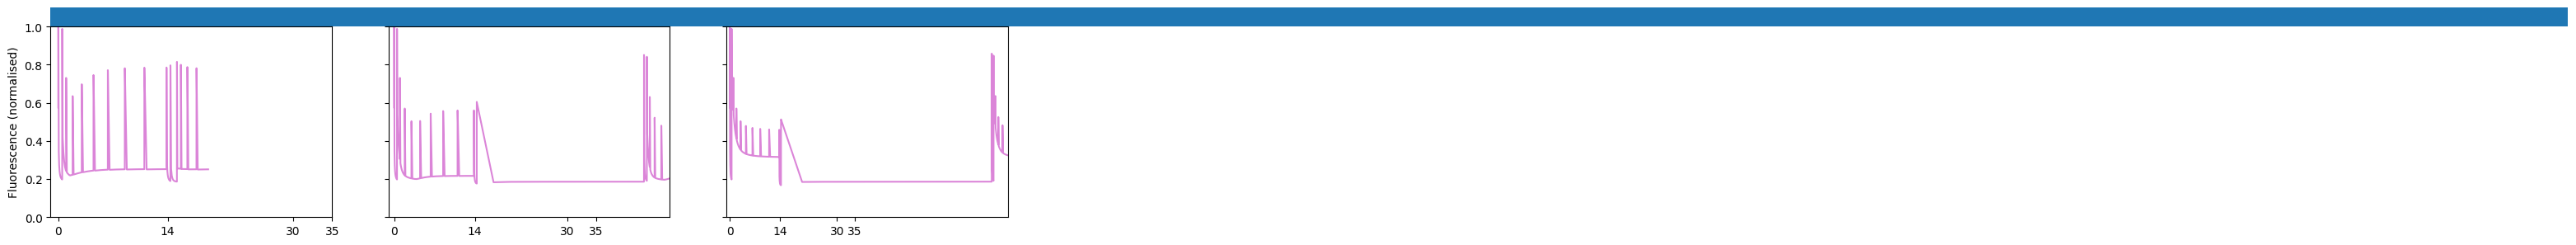

In [43]:
res = [
    {'sim': s1, 'protocol': pam_protocol1},
    {'sim': s2, 'protocol': pam_protocol2},
    {'sim': s3, 'protocol': pam_protocol3},
]

fig, axs = plt.subplots(ncols=3, figsize=(15, 3), sharey=True)

for i in range(len(axs)):
    ax = axs[i]
    c = res[i]['sim'].get_full_results()
    pam_protocol = res[i]['protocol']

    ax.plot(c["Fluo"] / max(c["Fluo"]), color="#db85d8")
    # ax.plot(time, NPQ, linestyle="dashed", color="black", label="NPQ", lw=2)
    pam_protocol["x-coords"] = pam_protocol.index.total_seconds()
    pam_ptrc_cleaned = pam_protocol[pam_protocol['pfd'] != 5000]

    prior_x = -60
    for idx, items in pam_ptrc_cleaned.iterrows():
        ax.add_patch(Rectangle(
            (prior_x, 1),
            width=items['x-coords'],
            height=0.1,
            clip_on=False
        ))
        prior_x += items['x-coords']
    
    # plot.shade_protocol(
    #     pam_ptrc_cleaned['pfd'],
    #     ax=ax,
    #     vmin=0,
    #     vmax=100,
    #     add_legend=False,
    #     alpha=0.3
    # )

    ax.set_xlim(-60, c.index[-1])
    ax.set_ylim(0, 1.0)
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/60:.1f}"))
    print(ax.get_xticks())
    ticks_to_show = [0, 14, 30, 35]
    ax.set_xticks([i * 60 for i in ticks_to_show], ticks_to_show)

axs[0].set(
    ylabel="Fluorescence (normalised)",
)

plt.tight_layout()
plt.show()

In [ ]:

res = s.get_full_results()
F = res['Fluo']
plt.plot(res.index/60, F/max(F))
plt.xlabel('Time [min]')
plt.ylabel('Fluorescence')


pam_ptrc_cleaned = pam_protocol[pam_protocol['pfd'] != 5000]

plot.shade_protocol(
    pam_ptrc_cleaned['pfd'],
    ax=ax,
    vmin=pfd_dark,
    vmax=pfd_illumination,
    add_legend=False,
    alpha=0.3
)

plt.show()


In [ ]:
s1 = Simulator(Matuszynska2016())
s1.clear_results()

t_relax=120
t_pulse=0.8
numpeaks_phase0=2
numpeaks_phase1=10
pfd_dark=50
pfd_illumination=1000
pfd_pulse=5000

s1, pam_ptrc = pam2(
    s1,
    t_relax=t_relax,
    t_pulse=t_pulse,
    numpeaks_phase0=numpeaks_phase0,
    numpeaks_phase1=numpeaks_phase1,
    pfd_dark=pfd_dark,
    pfd_illumination=pfd_illumination,
    pfd_pulse=pfd_pulse,
)

print(pam_ptrc)

                         pfd
Timedelta                   
0 days 00:02:00           50
0 days 00:02:00.800000  5000
0 days 00:04:00.800000    50
0 days 00:04:01.600000  5000
0 days 00:06:01.600000  1000
0 days 00:06:02.400000  5000
0 days 00:08:02.400000  1000
0 days 00:08:03.200000  5000
0 days 00:10:03.200000  1000
0 days 00:10:04         5000
0 days 00:12:04         1000
0 days 00:12:04.800000  5000
0 days 00:14:04.800000  1000
0 days 00:14:05.600000  5000
0 days 00:16:05.600000  1000
0 days 00:16:06.400000  5000
0 days 00:18:06.400000  1000
0 days 00:18:07.200000  5000
0 days 00:20:07.200000  1000
0 days 00:20:08         5000
0 days 00:22:08         1000
0 days 00:22:08.800000  5000
0 days 00:24:08.800000  1000
0 days 00:24:09.600000  5000
0 days 00:26:09.600000    50
0 days 00:26:10.400000  5000
0 days 00:28:10.400000    50
0 days 00:28:11.200000  5000
0 days 00:30:11.200000    50
0 days 00:30:12         5000
0 days 00:32:12           50
0 days 00:32:12.800000  5000
0 days 00:34:1

[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1744094662001/work/sundials/src/cvodes/cvodes.c:8101][cvHandleFailure] At t = 1570.47075085294 and h = 0.0020407143211583, the corrector convergence test failed repeatedly or with |h| = hmin.


None


TypeError: 'NoneType' object is not subscriptable

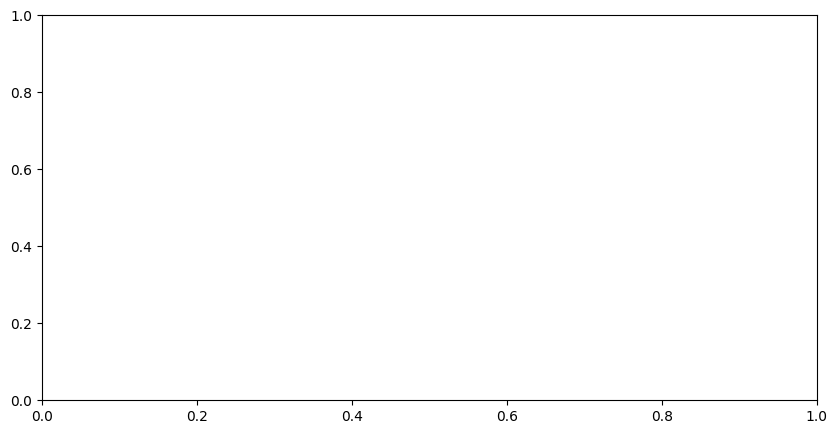

In [ ]:
from modelbase2 import plot
import matplotlib.pyplot as plt
    
